In [4]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict


In [5]:
load_dotenv(override = True)

True

In [6]:
# need a agent to look the text
# based on the best the agents decide which tools needs to be user and routed to that tool ( which does action)
# once the find the relevant tool it calls the tool
# generate the reponse whih will be redirected to the agent again to take decicion that it provided the right answer

In [11]:
# 


In [12]:
#custom the tools

pushover_user = os.getenv('PUSHOVER_USER')
pushover_token = os.getenv('PUSHOVER_TOKEN')
pushover_url = os.getenv('PUSHOVER_URL')


def push_notification(text:str)->str:
    payload = {"token":pushover_token, "user":pushover_user, "message":text }
    requests.post(pushover_url, data= payload)

In [13]:
# defint the tool
from langchain.agents import Tool

push_tool = Tool(
    name = "push_notification",
    func = push_notification,
    description = "send the push notification to the user using the pushover"
)

In [14]:
from langchain_community.utilities import GoogleSerperAPIWrapper
search = GoogleSerperAPIWrapper() 

In [15]:
search_tool = Tool(
    name = 'search the information from google',
    func = search.run,
    description ="search the content/information given by the user input from the google"
)

In [16]:
tools = [push_tool, search_tool]

In [17]:
class State(TypedDict):
    messages : Annotated[list, add_messages]


# state keeps a list of messages
# langagraph willk append new messages instead of overridinf them


# messages = ['hello','how are you doing',"i am doing great"]

In [18]:
graph_builder = StateGraph(State)

In [26]:
llm = ChatOpenAI(model = 'gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)

In [27]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x147ecac10>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x147f279d0>, root_client=<openai.OpenAI object at 0x147a20190>, root_async_client=<openai.AsyncOpenAI object at 0x147ec8a50>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'push_notification', 'description': 'send the push notification to the user using the pushover', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'search the information from google', 'description': 'search the content/information given by the user input from the google', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}]}, c

In [21]:
# create a node

def chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

    

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', ToolNode(tools =tools))

In [22]:
# create edges

graph_builder.add_conditional_edges("chatbot",tools_condition,"tools")

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")



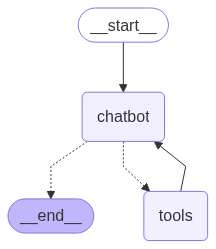

In [23]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
def chat(user_input:str,history):
    result = graph.invoke({"messages": [{'role':'user','content':user_input}]})
    return result['messages'][-1].content

In [ ]:
gr.ChatInterface(chat, type="messages").launch()

In [28]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [29]:
### sacing the in memory

In [30]:
config = {"configurable":{"thread_id" :'1'}}

In [31]:
config

{'configurable': {'thread_id': '1'}}

In [32]:
def chat(user_input:str,history):
    result = graph.invoke({'messages':[{'role':'user','content':user_input}]},config = config)
    return result['messages'][-1].content

In [33]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/Users/poorna/Desktop/llm_projects/projects/.venv/lib/python3.13/site-packages/gradio/queueing.py", line 667, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    )
    ^
  File "/Users/poorna/Desktop/llm_projects/projects/.venv/lib/python3.13/site-packages/gradio/route_utils.py", line 349, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<11 lines>...
    )
    ^
  File "/Users/poorna/Desktop/llm_projects/projects/.venv/lib/python3.13/site-packages/gradio/blocks.py", line 2274, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^
  File "/Users/poorna/Desktop/llm_projects/projects/.venv/lib/python3.13/site-packages/gradio/blocks.py", line 1779, in call_function
    prediction = await fn(*processed_input)
   

In [34]:
graph.get_graph(config)

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'chatbot': Node(id='chatbot', name='chatbot', data=chatbot(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'tools': Node(id='tools', name='tools', data=tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'push_notification': Tool(name='push_notification', description='send the push notification to the user using the pushover', func=<function push_notification at 0x14720f420>), 'search the information from google': Tool(name='search the information from google', description='search the content/information given by the user input from the google', func=<bound method GoogleSerperAPIWrapper.run of GoogleSerperAPIWrapper(k=10, gl='us', hl='en', type='search', result_key_for_type={'news': 'news', 'pl

In [35]:
list(graph.get_state_history(config))

ValueError: No checkpointer set

In [36]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect (db_path, check_same_thread= False)
sql_memory = SqliteSaver(conn)

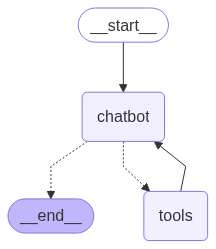

In [47]:
graph_builder = StateGraph(State)

# define an agent
llm = ChatOpenAI(model = 'gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)

# 
def chatbot(state:State):
    print(state)
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

tool_node = ToolNode(tools)

# build the node
graph_builder.add_node('chatbot',chatbot)
graph_builder.add_node('tools',tool_node)



# build the edges

graph_builder.add_conditional_edges('chatbot', tools_condition,'tools')

graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_edge(START,'chatbot')


#step 5
graph=graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))



config = {"configurable": {"thread_id": "3"}}

# config = {'configuration': {"thread_id": '3'}}
# 

def chat(user_input:str,history):
    result = graph.invoke({'messages':[{'role':'user','content':user_input}]},config = config)
    return result['messages'][-1].content

In [48]:
print(config)

{'configurable': {'thread_id': '3'}}


In [49]:
gr.ChatInterface(chat, type = 'messages').launch()

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hello\n', additional_kwargs={}, response_metadata={}, id='48be67d5-c71b-4ff8-98c0-375a3f5a8417')]}


Traceback (most recent call last):
  File "/Users/poorna/Desktop/llm_projects/projects/.venv/lib/python3.13/site-packages/gradio/queueing.py", line 667, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    )
    ^
  File "/Users/poorna/Desktop/llm_projects/projects/.venv/lib/python3.13/site-packages/gradio/route_utils.py", line 349, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<11 lines>...
    )
    ^
  File "/Users/poorna/Desktop/llm_projects/projects/.venv/lib/python3.13/site-packages/gradio/blocks.py", line 2274, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^
  File "/Users/poorna/Desktop/llm_projects/projects/.venv/lib/python3.13/site-packages/gradio/blocks.py", line 1779, in call_function
    prediction = await fn(*processed_input)
   